In [1]:
! git clone https://github.com/HackOverflowMais/Covid19Lung

fatal: destination path 'Covid19Lung' already exists and is not an empty directory.


In [2]:
%cd Covid19Lung


/content/Covid19Lung


In [3]:

!pip install -r requirements.txt

# Import Dependencies
import numpy
import pandas
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import shutil
import cv2
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
from pathlib import Path

# Keras Stuff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
p_covid = Path("./data/CT_COVID")
p_not_coivd = Path("./data/CT_NonCOVID")
p_cov_len = len([x for x in p_covid.iterdir()])
p_not_cov_len = len([x for x in p_not_coivd.iterdir()])
print(f"Scans Covid: {p_cov_len}\nScans with No Covid: {p_not_cov_len}")
train_data_cov = int(0.9 * p_cov_len)
train_data_cov_no = int(0.9 * p_not_cov_len)
print(f"Train Data COVID: {train_data_cov}\nTest Data Covid: {p_cov_len - train_data_cov}\nTrain Data NO COVID: {train_data_cov_no}\nTest Data No Covid: {p_not_cov_len - train_data_cov_no}")

Scans Covid: 349
Scans with No Covid: 397
Train Data COVID: 314
Test Data Covid: 35
Train Data NO COVID: 357
Test Data No Covid: 40


In [5]:
# Move Test Files Away
os.makedirs("./train/covid",exist_ok=True)
os.makedirs("./train/notcovid",exist_ok=True)
os.makedirs("./test/covid",exist_ok=True)
os.makedirs("./test/notcovid",exist_ok=True)
print("Made Dirs")

Made Dirs


In [6]:
random.seed(456)
train_data_cov_to_move = random.sample([x for x in p_covid.iterdir()], train_data_cov)
file_name_train_cov = [str(f).split("/")[2] for f in train_data_cov_to_move]
for i in range(len(train_data_cov_to_move)):
    shutil.copy(f"./data/CT_COVID/{file_name_train_cov[i]}",f"./train/covid/{file_name_train_cov[i]}")

print(f"Moved {len(file_name_train_cov)} train covid")

c = 0
to_mov_test_cov = [str(x).split("/")[2] for x in p_covid.iterdir()]
for file in to_mov_test_cov:
    if file not in file_name_train_cov:
        file = file.replace("\\","/")
        shutil.copy(f"./data/CT_COVID/{file}", f"./test/covid/{file}")
        c += 1
print(f"Moved {c} test covid")

Moved 314 train covid
Moved 35 test covid


In [7]:
train_data_no_cov_to_move = random.sample([x for x in  p_not_coivd.iterdir()], train_data_cov_no)
file_name_train_no_cov = [str(f).split("/")[2] for f in train_data_no_cov_to_move]
for i in range(len(train_data_cov_to_move)):
    shutil.copy(f"./data/CT_NonCOVID/{file_name_train_no_cov[i]}",f"./train/notcovid/{file_name_train_no_cov[i]}")

print(f"Moved {len(file_name_train_no_cov)} train nocovid")

c = 0
to_mov_test_no_cov = [str(x).split("/")[2] for x in p_not_coivd.iterdir()]
for file in to_mov_test_no_cov:
    if file not in file_name_train_no_cov:
        shutil.copy(f"./data/CT_NonCOVID/{file}", f"./test/notcovid/{file}")
        c += 1
print(f"Moved {c} test nocovid")

Moved 357 train nocovid
Moved 40 test nocovid


In [8]:
# Some Config Vars
batch_size_number = 64
epoch = 50
h = 150
w = 150

total_train = len([c for c in os.listdir("./train/covid")]) + len([c for c in os.listdir("./train/notcovid")])
total_test = len([c for c in os.listdir("./test/covid")]) + len([c for c in os.listdir("./test/notcovid")])

In [9]:
train_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [10]:

train_data_loc = os.path.join("./train")
train_data_proc = train_image_generator.flow_from_directory(batch_size=batch_size_number,
                                                            directory=train_data_loc,
                                                            shuffle=True,
                                                            target_size=(h,w),
                                                            class_mode='binary')


Found 709 images belonging to 2 classes.


In [11]:
test_data_loc = os.path.join("./test")
test_data_proc = train_image_generator.flow_from_directory(batch_size=batch_size_number,
                                                            directory=test_data_loc,
                                                            shuffle=True,
                                                            target_size=(h,w),
                                                            class_mode='binary')

Found 109 images belonging to 2 classes.


In [12]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(h, w, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [16]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [17]:
model.compile(optimizer='adam',loss=BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max',restore_best_weights=True)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='max')

history = model.fit_generator(
    train_data_proc,
    steps_per_epoch=(total_train//batch_size_number),
    epochs=epoch,
    validation_data=test_data_proc,
    validation_steps=total_test//batch_size_number,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
11/11 [==============================] - 6s 277ms/step - loss: 1.5690 - accuracy: 0.5502 - val_loss: 0.7057 - val_accuracy: 0.1875
Epoch 2/50
11/11 [==============================] - 3s 279ms/step - loss: 0.6587 - accuracy: 0.5244 - val_loss: 0.6044 - val_accuracy: 0.4844
Epoch 3/50
11/11 [==============================] - 3s 271ms/step - loss: 0.6234 - accuracy: 0.6030 - val_loss: 0.5356 - val_accuracy: 0.5625
Epoch 4/50
11/11 [==============================] - 3s 279ms/step - loss: 0.5638 - accuracy: 0.6543 - val_loss: 0.4821 - val_accuracy: 0.6875
Epoch 5/50
11/11 [==============================] - 3s 277ms/step - loss: 0.4713 - accuracy: 0.7662 - val_loss: 0.5115 - val_accuracy: 0.7812
Epoch 6/50
11/11 [==============================] - 3s 277ms/step - loss: 0.4429 - accuracy: 0.7782 - val_loss: 0.4568 - val_accuracy: 0.7500
Epoch 7/50
11/11 [==============================] - 3s 270ms/step - loss: 0.3657 - accuracy: 0.8101 - val_loss: 0.3834 - val_accuracy: 0.7656
Epoch 

In [22]:
model.save("Lungs.h5")

In [18]:
dat_pred = (model.predict_generator(test_data_proc) > 0.5).astype(int)
dat_actual =  test_data_proc.classes

for name, value in zip(model.metrics_names, model.evaluate_generator(test_data_proc)):
    print(f'{name}: {value}')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss: 0.5490543246269226
accuracy: 0.8440366983413696


In [19]:
# Jaccard Score

print(f"Jaccard Score: {jaccard_score(dat_actual, dat_pred)}")

Jaccard Score: 0.5588235294117647


In [20]:
#f1 Score

print(f"f1 score: {f1_score(dat_actual, dat_pred)}")

f1 score: 0.7169811320754716


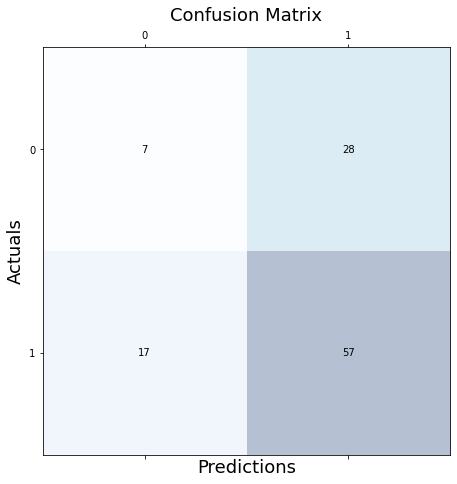

In [21]:
%matplotlib inline

# Confusion Matrix

conf_mat = confusion_matrix(dat_actual, dat_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j],va='center',ha='center')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()